In [1]:
import numpy as np
import scipy.io
from scipy import stats
from copy import copy
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as spo
from sklearn.linear_model import ElasticNet
import numpy.linalg as npl
import numpy.random as npr
from scipy.stats.mstats import linregress
from sklearn.decomposition import PCA
root2over = 1/np.sqrt(2)
erf_max = sp.special.erf(root2over)

#function to standardize the MEG data matrices, which have very small values around e-13, e-14
def standardize(data_matrix):
    #create a copy of the data_matrix and make it normalized_sensor_matrix, will just replace values in row during loop
    x = data_matrix[:]
    x-=np.mean(x) # the -= means can be read as x = x- np.mean(x)
    x/=np.std(x) # the /= means can be read as x = x/np.std(x)
    return x

# helper function to store all the sensor labels across patients present in the total dataset
def store_labels(sensor_labels, patient):
    all_sensor_labels = []
    for i in range(sensor_labels.shape[0]):
        new_tag = sensor_labels[i][0][0]+"_"+patient
        all_sensor_labels.append(new_tag)
    return all_sensor_labels

def store_reg_labels(sensor_labels, patient):
    all_sensor_labels = []
    for i in range(sensor_labels.shape[0]):
        new_tag = sensor_labels[i][0][0]
        all_sensor_labels.append(new_tag)
    return all_sensor_labels

#function to load the MEG data from an array with all the patient ids. Returns the raw and normalized MEG data
def load_sensor_matrix(id_list):
    labels_dict = {}
    separated_dataset = {}
    first_iteration = True   #boolean value that accomodates the first run through of MEG data
    for patient in id_list:
        data = scipy.io.loadmat('HCP_dataset/'+patient+'/MEG/Restin/rmegpreproc/'+patient+'_MEG_3-Restin_rmegpreproc.mat')
        data_times = data['data'][0][0][5][:]    #extracts the timecourses of the MEG data
        data_labels = data['data'][0][0][6][:]  #extracts the sensor labels for the MEG data
        data_trials = data['data'][0][0][4][:]   #extracts the MEG potentials over the given timecourse
        separated_dataset[patient] = data_trials[0][0]
        if first_iteration:
            sensor_matrix = data_trials[0][0][:]
            first_iteration = False    #no longer in the first iteration of the loop, set to false
        else:
            #if not in the first run through, append the matrices together, to form a combined matrix
            sensor_matrix = np.concatenate((sensor_matrix, data_trials[0][0][:]), axis = 0)
        #create an array with all the sensor_labels for every patient in the dataset
        all_data_labels = store_labels(data_labels, patient)
        labels_dict[patient] = set(store_reg_labels(data_labels, patient))
    return sensor_matrix, separated_dataset, all_data_labels, labels_dict

def common_labels(labels_dict):
    s = set()
    labels_dict_values = list(labels_dict.values())
    for index in range(len(labels_dict_values)-1):
        if bool(s) == False:
            s = set(labels_dict_values[index]).intersection(labels_dict_values[index+1])
        else:
            s = s.intersection(set(labels_dict_values[index+1]))
    return s

def form_dataset(common_labels_set, separated_dataset, labels_dict):
    streamlined_dataset = {}
    for patient in separated_dataset:
        for label in common_labels_set:
            channel_number = list(labels_dict[patient]).index(label)
            if patient not in streamlined_dataset:
                streamlined_dataset[patient] = [separated_dataset[patient][channel_number, :]]
            else:
                streamlined_dataset[patient].append(separated_dataset[patient][channel_number, :])
    return streamlined_dataset

def find_sigma(y,h):
    time_steps,size = y.shape
    sigma = np.std(y-h,axis=0)
    #     sigma = np.random.rand(1,size) + 0.5
    #     for index in range(size):
    #         def f0(sig):
    #             return (1-np.std(y[:,index]/np.abs(sig) - h[:,index]))**2
    #         res = spo.minimize(f0,sigma[0,index])
    #         sigma[0,index] = np.abs(res.x)
    return(sigma.reshape(1,size))

def time_shift_cov(x,shift=1):
    time_steps,size = x.shape
    x0 = (x - np.mean(x,axis=0))/np.std(x,axis=0)
    return x0[shift:].T.dot(x0[:-shift])/np.float(time_steps-shift)

def enet_solve(c,b):
    regr = ElasticNet(random_state=0,max_iter=10000)
    regr.fit(c,b)
    return regr.coef_

def moving_avg(a,window):
    cu = np.cumsum(a,axis=0,dtype=float)
    cu[window:] = cu[window:] - cu[:-window]
    return cu[window-1:]/window

def odd_power(h,power=3):
    sign = np.sign(h)
    return sign*np.power(np.abs(h),1/power)

#Now add in a bias
def simulate(size,time_steps,w = 0.0,sigma = 1.0,coupling = 1.0,rho = 0.2,power=1,delta = 1,bias=0, initial=0):
    if npl.norm(w)==0.:
        sigma = (npr.rand(1,size)+1)/2.0        
        delta = odd_power(npr.rand(1,size)+1,power)        
        bias = (npr.rand(1,size)-0.5)*2
        w = npr.rand(size,size) - 0.5
        w = coupling*w - rho*np.eye(size)
    x = np.zeros((time_steps,size))
    x_min = np.zeros((1,size))
#     if initial == 0:
#         x[0] = npr.rand(1,size)-0.5
#     else:
    x[0] = initial
    print(initial)
    for i in range(time_steps-1):
        x[i+1] = (1)*x[i] + delta * odd_power(bias + x[i].dot(w),power) + sigma*npr.normal(size=(1,size))
    y = np.diff(x,axis=0)
    y_max = np.max(np.abs(y),axis=0)
    opd = odd_power(delta,1/power)
    if not np.isscalar(delta):
        opd = odd_power(delta,1/power)
        return x,opd[0][None,:]*w,sigma,opd*bias
    else:
        return x,w,sigma,bias

def bias_update(y,h,b_in,pp):
    y_plus = y>0
    def f0(bias):
        return np.mean(y[y_plus]-odd_power(bias + h[y_plus],pp))**2 + np.mean(y[~y_plus]-odd_power(bias + h[~y_plus],pp))**2
    res = spo.minimize(f0,b_in)
    return res.x


def infer(x,max_iter = 100,tol=1e-8,func=npl.solve,window=1,power=1,verbose=False):
    time_steps,size = x.shape
    x0 = np.copy(x)
    if window>1:
        x0 = moving_avg(x0,window)
        time_steps = time_steps-window+1
    y = np.diff(x0,axis=0)
    y_mean = np.mean(np.abs(y),axis=0)
    y_max = np.max(np.abs(y),axis=0)
#     if power<3:
#         y /= y_max[None,:]#now y is definitely within +/- 1
#         x0 = x0/y_max[None,:]
    x0 = x0[:-1]
    s = np.sign(y)
    c = np.cov(x0,rowvar=False)
    w = npr.rand(size,size) - 0.5
    bias = npr.rand(1,size) - 0.5
    h = odd_power(bias + x0.dot(w),power)
    for index in range(size):
        err_old,error,counter = 0,np.inf,0
        #         print(index)
        while np.abs(error-err_old) > tol and counter < max_iter:
            counter += 1
            zeros = np.abs(bias[0,index] + x0.dot(w[:,index])) < 1e-7
            ratio = np.sqrt(np.pi/2.0)*np.ones((time_steps-1))*h[:,index]**(power-1)
            ratio[~zeros] = (bias[0,index] + x0[~zeros,:].dot(w[:,index]))/sp.special.erf(h[~zeros,index]*root2over)
            w[:,index] = func(c+0.1*np.eye(size),np.mean((x0-np.mean(x0,axis=0)[None,:])*(s[:,index]*ratio)[:,np.newaxis],axis=0))
            h_temp = x0.dot(w[:,index])
            bias[0,index] = bias_update(y[:,index],h_temp,bias[0,index],pp=power)
            err_old = error
            h[:,index] = odd_power(bias[0,index] + h_temp,power)
            error = npl.norm(s[:,index]-sp.special.erf(h[:,index]*root2over))
#             print(counter,error)
    sigma = find_sigma(y,h)*np.sqrt(window)#*y_max[None,:]
    return w,sigma,bias

def pca_combine_datasets(streamlined_dataset):
    pca_combined_dataset = np.array([])
    for patient in streamlined_dataset:
        x = np.asarray(streamlined_dataset[patient])
        if pca_combined_dataset.size == 0:
            pca_combined_dataset = x
        else:
            pca_combined_dataset = np.concatenate((pca_combined_dataset, x), axis=1 )
    return pca_combined_dataset

def calculate_allW(dataset, given_power):
    allwmatrices = {}
    allsigs = {}
    allbiases = {}
    for patient in dataset:
        w, sig, bias = infer(dataset[patient].transpose(), power=given_power)
        allwmatrices[patient] = w
        allsigs[patient] = sig
        allbiases[patient] = bias
    return allwmatrices, allsigs, allbiases

def calculate_allTimeCov(dataset, time_shift):
    alltimeshiftcov = {}
    for patient in dataset:
        timeshiftcovmatrix = time_shift_cov(dataset[patient].transpose(), shift=time_shift)
        alltimeshiftcov[patient] = timeshiftcovmatrix
    return alltimeshiftcov

def hcp_inference(dataset_ids, pca_components, time_shift, power):
    print("Running Newest Inference Linear with Power Fixed:")
    print("1. PCA components =", pca_components)
    print("2. Time shifts =", time_shift)
    print("3. Power =", power)
    sensor_matrix, separated_dataset, all_data_labels, labels_dict = load_sensor_matrix(dataset_ids)
    common_labels_set = common_labels(labels_dict.copy())
    streamlined_dataset = form_dataset(common_labels_set.copy(), separated_dataset.copy(), labels_dict.copy())
    normalized_streamlined_dataset = {}
    for patient in streamlined_dataset:
        normalized_streamlined_dataset[patient] = standardize(streamlined_dataset[patient])
    pca_data_dict = {}
    pca_combined_dataset = pca_combine_datasets(normalized_streamlined_dataset.copy())
    pca = PCA(n_components=pca_components)
    pca.fit(pca_combined_dataset.T)
    transformed_data = pca.fit_transform(pca_combined_dataset.T)
    counter = 0
    for patient in normalized_streamlined_dataset:
        pca_data_dict[patient] = transformed_data[counter*1018:1018*(counter+1), :].T
        counter = counter + 1
    allwmatrices, allsigs, allbiases = calculate_allW(pca_data_dict, power)
    alltscmatrices = calculate_allTimeCov(pca_data_dict, time_shift)
    return allwmatrices, alltscmatrices, allsigs, allbiases, pca_data_dict

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import linregress
%matplotlib inline

In [3]:
power = 1
pca_components = 10
time_shift = 10
dataset_ids = ['100307', '102816', '105923', '106521', '108323', '109123', '111514', '112920', 
               '116524', '116726', '133019', '140117', '146129', '149741', '153732', '154532', 
               '156334', '158136', '162026', '162935', '164636', '166438', '169040', '172029', 
               '174841', '175237', '175540', '177746', '179245', '181232', '185442', '187547', 
               '189349', '191033', '191437', '191841', '192641', '195041', '198653', '204521', 
               '205119', '212318', '212823', '214524', '221319', '223929', '233326', '248339', 
               '250427', '255639', '257845', '283543', '287248', '293748', '352132', '352738', 
               '353740', '358144', '406836', '433839', '512835', '555348', '559053', '568963', 
               '581450', '599671', '601127', '660951', '662551', '665254', '667056', '679770', 
               '680957', '706040', '707749', '715950', '725751', '735148', '783462', '814649',
               '825048', '872764', '877168', '891667', '898176', '912447', '917255', '990366']

In [4]:
allwmatrices, alltscmatrices, allsigs, allbiases, pca_data_dict = hcp_inference(dataset_ids, pca_components, time_shift, power)

Running Newest Inference Linear with Power Fixed:
1. PCA components = 10
2. Time shifts = 10
3. Power = 1


In [5]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_linear_10trials = []
counter = 0
pvalue_bytimeshift = []
timeshifts = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for timeshift in timeshifts:
    for i in range(20):
        pvalue_linear_array = []
        for patient in allwmatrices:
            w = allwmatrices[patient]
            sig = allsigs[patient]
            bias = allbiases[patient]

            x_original = pca_data_dict[patient].T.copy()

            # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=1, bias=bias, initial=x_original[0])

            # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
            tsc_original = time_shift_cov(x_original, shift=timeshift)
            tsc_simulated = time_shift_cov(simulated_data[0], shift=timeshift)


            line_object = linregress(tsc_original, tsc_simulated)
    #         plt.title('Patient ' + str(patient))
    #         plt.xlabel('time_shift_cov original')
    #         plt.ylabel('time_shift_cov simulated')
    #         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
    #         plt.plot([-1, 1], [-1,1], 'r--')
    #         time_shift_axes = np.arange(-1, 2)
    #         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    #         plt.show()
    #         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    #         print("--------------------------------------------------------------")
            pvalue_nonlinear_average += line_object.pvalue
            pvalue_linear_array.append(line_object.pvalue)
            slope_average += line_object.slope
            counter += 1
        pvalue_linear_10trials.append(np.mean(pvalue_linear_array))
    print('mean', np.mean(pvalue_linear_10trials))
    print('std', np.std(pvalue_linear_10trials))
    pvalue_bytimeshift.append(np.mean(pvalue_linear_10trials))
print(pvalue_bytimeshift)

[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14

[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.

[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  

[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3

[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07

[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04

[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.

[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.8

[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 

[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.8

[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.

[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881 

[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44

[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03

[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99

[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.

[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  

[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61

[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88

[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70

[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.

[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00 

[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.2

[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00

[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.1

[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.

[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53

[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68

[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70

[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.

[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   

[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53

[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68

[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.941

[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.

[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   

[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3

[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88

[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04

[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.

[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51

[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -

[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.4

[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.0

[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881 

[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43

[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03

[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.247

[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.

[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -

[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.9

[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00

[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.1

[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.

[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00 

[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -

[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.4

[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.1

[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.

[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84

[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -

[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33

[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.

[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.

[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426

[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -

[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.8

[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.0

[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.

[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84

[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 

[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33

[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.1

[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.

[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.8741

[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -

[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59

[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.

[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.

[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426

[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -

[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.4

[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.1

[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.

[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426

[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  

[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.247

[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.

[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  

[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.3

[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07

[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70

[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.

[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00 

[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.9

[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.4

[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98

[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.

[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  

[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61

[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88

mean 0.08715327511439211
std 0.05836151916889019
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.244

[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.

[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.8

[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   

[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33

[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.1

[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.

[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.1144

[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -

[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59

[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.

[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  

[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.9

[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.432

[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.4

[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.

[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00 

[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -

[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35

[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.4

[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.

[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51

[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.894605

[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59

[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.

[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.

[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44

[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.4

[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0

[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.

[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426

[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -

[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59

[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.

[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  

[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3

[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00

[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.5

[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.

[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.61

[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -

[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.247

[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.

[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881 

[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53

[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32

[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14

[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.

[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -

[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.9

[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07

[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
mean 0.11888993013688823
std 0.0668288878688989
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.9034

[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.

[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  

[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53

[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68

[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.617

[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.

[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  

[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61

[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.4

[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.4

[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.

[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.61

[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  

[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00

[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.1

[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.

[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.8

[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 

[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.8

[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.

[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 

[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44

[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68

[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98

[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.

[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.8

[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -

[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35

[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.1

[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.

[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44

[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88

[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04

[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.

[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72

[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -

[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33

[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.1

[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.

[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51

[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -

[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6

[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.

[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  

[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61

[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07

[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0

[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.

[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426

[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  

[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.617

[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.

[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  

[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.3

[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.432

[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.5

[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.

[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51

[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -

[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99

[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.

[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.

[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426

[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 

[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.4

[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.

[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 

[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44

[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32

[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.247

[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.

[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  

[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43

[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.347

[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.4

[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.

[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.56722334 -7.31476741  1.2476638  -0.67556754 -0.22563501  0.38428749
 -2.60482883  1.07720452  0.67235425 -2.71852519]
[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.61

[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -

[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.85780546  0.78777248 -1.31880259 -0.75932207  0.95827675
 -0.38875145 -1.77157599 -0.58912707 -0.05369338]
[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33

[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.18318748 -0.41506773  0.16045322 -1.47370302  0.21818271
  0.7516889  -0.25362029 -1.09165821 -0.48097031]
[-0.45088972 -3.4

[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.05275314 -0.52334613 -2.43693657 -0.1766265  -2.29344454
  0.68565681  0.15673689  0.03106817  0.05280631]
[ 2.60332871  5.

[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44

[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  

[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99

[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.

[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00  6.04735259e-01  1.35374364e+00  1.22609267e-03
 -6.64459538e-01 -4.73264625e-01  9.39518219e-01  2.63261132e+00
 -1.11390937e+00  1.83325171e+00]
[-1.01951287  0.16811154 -0.61478477  0.46919954 -4.83937808  2.00789536
  0.62689285  0.32182988 -2.75773531  0.1464436 ]
[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   

[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -2.268868   -2.10881338]
[ 0.48989985 -3.35474331  2.38299514 -2.9671487   1.49216669  0.11292501
  1.46172634  0.0572669   1.68122736 -0.75490633]
[-3.92736099  1.76083309 -3.28030787 -1.83731365  3.74168345 -0.68526496
  2.01161722 -2.05223055  0.90838036 -2.10372675]
[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3

[ 0.2479118  -0.48529037  1.88828128 -0.09426699  2.92122287  0.446274
 -0.40763712  0.57046057  1.76462504 -0.50923991]
[-0.12179751 -1.33427262 -2.61807222  0.65106358  0.21194305  0.43049286
  1.35202341  0.80093559 -0.27052364 -0.69771615]
[-0.54767347  0.71360318 -4.6897788   7.20646933  0.81673121  1.44474467
  1.40077559  0.5813819  -0.36595878  0.74549939]
[-2.61688804 -0.35593919 -0.82586463 -3.45510156  0.65193924 -0.22136221
 -0.43479011  1.31123604  0.6384067   0.71042662]
[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.347

[-0.45088972 -3.43956167  1.2109169   2.13470815  1.12079718  0.29601736
 -0.72483494 -0.48837059 -0.43822621 -0.31081436]
[-3.13652367  3.56533132 -0.66250029  1.32142288 -1.34338345 -0.97881691
 -0.38410981  1.13733399 -0.95833582  0.5494469 ]
[ 1.29890124 -0.46817238  3.46246832 -5.76974842 -0.21639114  0.26223286
  2.14364163  0.73342105  1.63905787 -0.64074018]
[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98

[ 2.60332871  5.73328965 -2.48571905  2.99514076 -1.79812637 -1.72545867
  2.50551838 -0.75847018 -1.40975276  1.43505023]
[ 4.66383021  1.88614218  0.18498814  0.04205141  1.21569007  1.86804629
 -1.64707677 -2.19090413  0.22443332  1.1783963 ]
[-6.16243046  3.26118444 -5.28038032  2.69109349 -1.16576549 -1.44057318
 -0.93242572  1.69722946 -4.83442889 -0.63103388]
[-0.64987757 -2.57389973  4.00174867 -4.40582965 -1.24129433  0.96981994
  1.04437719 -0.42397772 -1.37501575 -1.04141548]
[ 2.37012105 -0.86445271 -3.06068786  0.49623152  2.32909816  1.50551883
  0.32951171  1.03491326  1.31881276 -0.06008905]
[ 0.90281335  1.89328096 -2.70284972  1.77997654 -0.27469991 -1.68148916
  0.70774518 -0.0196186   0.76943777 -0.20376671]
[-0.33853741  1.89624121  2.21235063  2.77962301 -0.98871629 -1.93315876
  2.10644525  0.11305462  1.02419139 -1.58502288]
[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.

[-5.87413636  4.00681038 -2.98825372  2.16602656  4.71816446 -3.16055128
  0.66629309 -0.65921468  1.13675349  0.0514447 ]
[-0.11449615 -0.8282372   1.31664355 -0.32228291 -0.56237914 -0.89972342
  0.8107443   0.4450263  -1.22848671 -0.53527845]
[-1.4426533  -2.42644768  0.97970878  1.01316127 -0.03213489  1.35538086
 -0.768941    0.49053199  0.31828715  0.7323537 ]
[-3.04807649  0.84501664  1.44457324  2.80792923 -3.52872769 -1.90089795
  0.21405377  1.46469919  1.18498932 -0.9048219 ]
[ 0.60808453 -2.51930094 -2.13312633  0.00599889 -0.58214541 -1.77590125
 -0.1031132   2.29205536  0.68100172  0.58896657]
[ 1.88006236 -1.6187183  -1.60719273 -2.75791467 -1.53320865  0.57973775
  1.79608921  1.73407539 -0.26348575  0.51288362]
[-2.62634475 -2.72014693  1.57621764  1.05421531 -0.07033635  1.5046769
  0.44149679  0.63679462 -0.5984432   1.85840723]
[ 1.23758891  3.83253649  0.76111033 -1.81263277  1.12766438 -0.47979334
  1.37094025  0.85914489 -0.96118631 -1.89265687]
[ 2.10086124e+00 

[-3.45051992 -5.68252057 -4.34610092  2.60012508 -2.39970077  2.48963706
  2.266559    0.71256838  1.36006186 -1.49764193]
[-1.58670136  0.03323253  1.11538322 -0.88992738 -0.53799606 -2.57907479
 -1.54467875 -0.73064174  0.82764947  0.80168085]
[-3.86690441e-04  2.44224967e+00 -9.44677769e-01 -2.40024606e+00
  1.39441691e-01 -5.90827934e-02 -1.36974100e+00 -3.75909823e-02
 -2.89460558e-01 -2.14373615e-01]
[-1.10921854 -3.03378047 -0.40565428 -1.51840061 -1.83293351 -0.33832143
  0.96866342 -4.21886651 -1.53743164 -0.00799187]
[ 6.67511117 -5.01505149 -2.09290511 -1.60506015 -0.51453886 -0.84889614
 -1.29340566 -1.29895807 -0.45965028 -0.09706363]
[-1.15073244 -2.36237838 -6.9071207   3.47426554  0.6335824   1.11373519
  0.06126926 -0.24313632 -0.36291695  1.06762104]
[-0.14661576 -4.38359122  0.18744426  3.67815527 -1.54098444  3.4458472
  0.22683964  2.24712521 -0.73734405 -1.09055324]
[-0.68869508  4.01408244  4.09790164 -0.99886617  1.17892254 -0.10570166
  0.60632711  0.10248953 -

[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.61779165  0.84633907 -0.62184311 -0.14716992 -0.31759927
 -0.75931319  0.46360607  0.18904473 -0.97133167]
[ 5.14059024 -3.59411129  1.52508084  0.34741491 -1.32381379 -2.21053264
 -0.06210031  0.99080493 -1.97387457  0.026389  ]
[-5.03000908  0.99624671 -1.95932048 -0.45826074  1.45771738  0.42802411
  1.73483658 -0.06071029  2.42588923  1.71333734]
[ 1.10239145 -1.6010221  -6.3376231  -1.80638724 -0.73722135 -1.56605878
  1.65579749 -1.0371326  -0.12887591 -0.924486  ]
[-0.29790681 -0.8

[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.18222563 -1.44232408 -2.55473067 -0.71377728 -2.18860117
 -1.30692242  0.36623908 -0.56349212  0.97400724]
[ 8.56860322 -1.32837578 -2.20551962  2.75541817  2.96124474  0.90836055
  3.10060976  1.78957475 -0.92732057  2.93217234]
[-0.5883916   1.46502253  0.58793171  1.96367792  1.71618986  0.4672725
 -1.43895448  0.13386456  0.41262067  0.03479   ]
[-2.33703978  1.03789044 -0.2981062   2.02324433  1.00071696  1.17232085
 -0.83566374 -0.12754511  0.26022091  0.27679852]
[-1.05561157 -0.10312104 -1.89276413  0.55424145 -1.56749427  0.42470337
  0.55870995  1.09093021 -0.11133884  0.14185068]
[ 3.08864686 -1.1

[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.

[ 0.56349414 -1.75634173  0.0242232  -3.33607024 -1.11786816 -1.14766773
 -0.97886098 -1.35966309 -0.82429122  0.23359517]
[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44

[ 0.5843502  -0.75374651 -3.11060865 -0.95015845 -2.10338218 -0.63801924
 -1.20916668 -0.03998716  0.94518383  0.7537903 ]
[ 4.26381546 -5.00083175  3.42106052  2.46784964  1.29271309 -0.62487244
  2.61565716 -2.47646994  1.44859801 -0.48910432]
[ 4.58992789 -0.07693428 -0.49321442  1.07236523  1.48197441  1.7339506
 -1.25366825 -1.01573287 -0.51898733 -0.67784874]
[ 2.17187341 -4.43207112 -1.98368744  0.13830705 -0.95074447  0.64083847
 -0.37171838  0.80382809 -0.16930645  0.2292807 ]
[ 8.8903977  -0.34764891  1.60747922  1.68419561 -0.27338605 -1.73006861
 -0.69479368 -0.0376955  -1.29519937  1.37161698]
[ 3.21323814  0.47280915  0.82602391 -0.45735917 -1.73538519 -0.1151778
  0.77565403  1.75728945  0.18434144 -0.36760514]
[ 0.85989742 -0.88946447 -0.71667109  4.72401018  2.13304311 -0.31182645
  0.8210899   1.12709452 -0.38770837  0.29724796]
[ 6.21854676  0.32110621 -1.92995928  1.88694942 -0.51572104 -0.77051321
 -1.05557368  0.06413937 -1.33050705 -3.68546051]
[-3.45051992 -5.68

[-3.06905794  1.0377905  -2.41635765 -0.66068131 -0.64499679 -1.4028029
 -0.40527752 -0.98529409  1.06723479  0.65514742]
[-0.71484327  1.04440295 -0.84793115 -0.35418175 -1.23490508 -0.05337316
  0.11903186  0.6005898  -0.40419498 -0.32432732]
[ 7.51347801 -2.40684559  2.2693565  -2.10787026 -0.95106211 -1.3725268
  5.54768499  0.90341584  3.32678305 -0.7638997 ]
[ 9.5114471  -2.70932734  2.09789821  0.24370287  0.54007661 -2.85502236
  0.15434303  4.24462376 -1.75331326 -0.89299352]
[ 2.42953652  1.14253134 -0.00855386 -1.64647084 -1.70559748  1.39540442
 -1.89935843  0.88483562 -0.59620958  0.35698266]
[-0.54540608  3.98603459 -3.73045732  0.19574271  2.38011721 -3.0907756
  3.89966818  0.42601393 -2.06207751  1.0872332 ]
[ 0.751023    0.94142941 -0.97484091  0.07410267  0.25442187  1.37220401
  0.27503117 -0.00852689 -0.60973324 -0.48751652]
[ 0.80281957  2.24717941  0.84249026 -0.81137897 -0.72247508 -1.12082718
 -0.86143596 -0.4206913   0.31542889 -0.08346037]
[ 1.65465509  0.617

[ 6.07280244 -0.06925071  1.01179968  1.05651511  0.13719247  2.84927447
  1.24048178 -1.62948967  1.83310849  3.23027186]
[-0.42826406  0.32460921 -0.57289959 -1.12887344 -0.76178382 -3.01786777
  0.42772069  0.73969422  0.09900527 -1.06004821]
[ 0.64603118 -2.06669959  1.0149521  -0.73344105  1.1143233   0.30501593
 -0.46364611  3.11086552 -0.78844786  1.52548687]
[-2.50778846  3.09324722 -1.23361004 -1.01786081  2.34799295 -0.61349833
  0.94861482 -1.94613767 -1.36372153 -2.85164253]
[ 2.19194926  1.45503391 -0.02016517  0.28485806 -0.15473299 -2.81132009
 -1.32360736 -1.06953198 -0.62111699  0.6795423 ]
[-0.08601423  0.58794708 -1.75249225 -2.08014962  0.76210118  0.73564761
 -0.66691503  0.88857596 -0.15800813 -0.92118694]
[-0.78638453  4.83019413 -2.60645814 -5.08885952 -0.3597253   1.31841883
 -1.53072185  0.93493898 -0.15821608 -0.20238599]
[ 2.78712394  5.69564905  2.69059872 -2.76458034  0.18551358 -1.21225916
  0.47538237 -0.06617381 -2.55693191 -1.56440294]
[ 0.17480421 -2.

[-3.78694425  0.80709659 -1.63918068  0.64013651 -1.80235912 -1.09131173
  0.80909328  0.35018597  1.25396641  1.83571801]
[-4.19097592 -3.07927157  1.71660311 -1.34925511  0.46394618  0.75454562
 -2.15638022 -0.0911357   0.1411198  -2.14590789]
[ 0.23383682  3.61262155  2.46924322 -0.23982406 -1.07455153 -0.60853587
  0.40020297  0.55901114  1.55690501  0.59539743]
[ 2.43419421  2.37409622  1.59425399 -3.94563483  0.03909225  0.59880761
  0.20337654 -2.04818063  0.2903018  -0.94553775]
[ 1.51510307 -5.53440191  2.46152464 -1.53962583 -4.1677638   1.18334445
  2.85368382  0.98588246 -0.19913485 -0.26156101]
[ 7.78457557  0.5393613  -2.64782843 -3.83253557  2.9292147  -0.87550739
  2.62588208 -2.55085881  2.77084581  1.17742365]
[ 2.16280135  2.38807535  0.86533249  0.54185848 -1.42634413 -0.62570232
 -1.48001108 -0.18002344  0.85786584  0.49245894]
[-0.4515887  -2.07063885 -0.4838676   0.09274155  0.2728327   1.62139361
 -0.61240547 -0.31115345 -0.92227211 -0.26421007]
[ 2.9896084   1.

[ 0.59679053  0.21614927  2.70823811  1.55659603 -1.0662777  -1.00207606
 -0.47447853  1.51071972 -0.80279225 -0.85536048]
[ 1.08653553  0.94575148  0.19528289  1.64816027  1.22150146  0.66317253
  3.20661089  0.93280454 -0.1570334  -0.05210344]
[ 0.0648491   6.35674583 -0.0701775  -0.57161114 -1.96179821 -0.29148691
 -1.43444597  0.1040803  -0.5975019  -2.4070606 ]
[-10.66002829   3.75355456   0.75665326  -0.60355981   1.86920731
  -1.25966772  -2.73816076   0.87309872  -2.27500649  -2.3366234 ]
[-2.61176724 -2.13148604  2.18157332 -1.89010233 -1.0342746   1.89630048
 -0.36628926 -2.03247462 -0.81726228  0.8772555 ]
[ 1.53211684  0.85983112 -0.2460511   0.06367769 -1.88851339  0.33507071
 -0.87033871  0.13124311 -0.42061444  0.08415274]
[-2.43926355  5.14281587  0.40539324 -0.16659417  0.61950675  0.61854863
  0.26629969  2.00397544  0.61582328  0.17472365]
[-1.44317333 -2.10949345 -1.06674343 -0.97946281 -1.42740914 -0.596022
  0.22073413  0.66204598  1.091957   -0.17316498]
[-6.5672

In [6]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_linear_10trials = []
counter = 0
pvalue_linear_bytimeshift = []
timeshifts = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for timeshift in timeshifts:
    pvalue_linear_array = []
    for patient in allwmatrices:
        w = allwmatrices[patient]
        sig = allsigs[patient]
        bias = allbiases[patient]

        x_original = standardize(pca_data_dict[patient].T.copy())

        # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
        simulated_data_final = np.zeros((1018, pca_components))
        for i in range(50):
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=1, bias=bias)
            simulated_data_final += simulated_data[0]
        simulated_data_final = simulated_data_final/50

        # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
        tsc_original = time_shift_cov(x_original, shift=timeshift)
        tsc_simulated = time_shift_cov(simulated_data_final, shift=timeshift)


        line_object = linregress(tsc_original, tsc_simulated)
#         plt.title('Patient ' + str(patient))
#         plt.xlabel('time_shift_cov original')
#         plt.ylabel('time_shift_cov simulated')
#         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
#         plt.plot([-1, 1], [-1,1], 'r--')
#         time_shift_axes = np.arange(-1, 2)
#         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
#         plt.show()
#         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
#         print("--------------------------------------------------------------")
        pvalue_nonlinear_average += line_object.pvalue
        pvalue_linear_array.append(line_object.pvalue)
        slope_average += line_object.slope
        counter += 1
    print(np.mean(pvalue_linear_array))
    pvalue_linear_bytimeshift.append(np.mean(pvalue_linear_array))
print(pvalue_linear_bytimeshift)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

In [7]:
power2 = 3
pca_components = 10
time_shift = 10
dataset_ids = ['100307', '102816', '105923', '106521', '108323', '109123', '111514', '112920', 
               '116524', '116726', '133019', '140117', '146129', '149741', '153732', '154532', 
               '156334', '158136', '162026', '162935', '164636', '166438', '169040', '172029', 
               '174841', '175237', '175540', '177746', '179245', '181232', '185442', '187547', 
               '189349', '191033', '191437', '191841', '192641', '195041', '198653', '204521', 
               '205119', '212318', '212823', '214524', '221319', '223929', '233326', '248339', 
               '250427', '255639', '257845', '283543', '287248', '293748', '352132', '352738', 
               '353740', '358144', '406836', '433839', '512835', '555348', '559053', '568963', 
               '581450', '599671', '601127', '660951', '662551', '665254', '667056', '679770', 
               '680957', '706040', '707749', '715950', '725751', '735148', '783462', '814649',
               '825048', '872764', '877168', '891667', '898176', '912447', '917255', '990366']

In [8]:
allwmatrices2, alltscmatrices2, allsigs2, allbiases2, pca_data_dict2 = hcp_inference(dataset_ids, pca_components, time_shift, power2)

Running Newest Inference Linear with Power Fixed:
1. PCA components = 10
2. Time shifts = 10
3. Power = 3


In [9]:
# allwmatrices3, alltscmatrices3, allsigs3, allbiases3, pca_data_dict3 = hcp_inference(dataset_ids, pca_components, time_shift, power=5)

In [10]:
# allwmatrices4, alltscmatrices4, allsigs4, allbiases4, pca_data_dict4 = hcp_inference(dataset_ids, pca_components, time_shift, power=7)

In [11]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_10trials = []
counter = 0
pvalue_bytimeshift_nl = []
for timeshift in timeshifts:
    for i in range(20):
        pvalue_nonlinear_array = []
        for patient in allwmatrices2:
            w = allwmatrices2[patient]
            sig = allsigs2[patient]
            bias = allbiases2[patient]

            x_original = pca_data_dict2[patient].T.copy()

            # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=3, bias=bias, initial=x_original[0])

            # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
            tsc_original = time_shift_cov(x_original, shift=timeshift)
            tsc_simulated = time_shift_cov(simulated_data[0], shift=timeshift)


            line_object = linregress(tsc_original, tsc_simulated)
    #         plt.title('Patient ' + str(patient))
    #         plt.xlabel('time_shift_cov original')
    #         plt.ylabel('time_shift_cov simulated')
    #         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
    #         plt.plot([-1, 1], [-1,1], 'r--')
    #         time_shift_axes = np.arange(-1, 2)
    #         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    #         plt.show()
    #         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    #         print("--------------------------------------------------------------")
            pvalue_nonlinear_average += line_object.pvalue
            pvalue_nonlinear_array.append(line_object.pvalue)
            slope_average += line_object.slope
            counter += 1
        pvalue_10trials.append(np.mean(pvalue_nonlinear_array))
    print('mean', np.mean(pvalue_10trials))
    print('std', np.std(pvalue_10trials))
    pvalue_bytimeshift_nl.append(np.mean(pvalue_10trials))
print(pvalue_bytimeshift_nl)

[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.1

[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.

[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.8

[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 

[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.4

[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.0

[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.2

[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6

[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 

[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61

[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.

[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -

[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3

[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43

[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.4

[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.

[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.7

[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 

[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.5

[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.

[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -

[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43

[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.

[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9

[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.

[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6

[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 

  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.9

[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.

[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -

[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.2

[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.35

[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.1

[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.2

[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.

[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 

[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.6

[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.

[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167 

[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.611

  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49

[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.5

[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.

[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.

[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 

[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.8

[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.

[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -

[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53

[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43

[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.4

[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.8

[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87

[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.

[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24

[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.

[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  

[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.3

[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43

[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.4

[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.

[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.

[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333

[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.5

[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.

[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167 

[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.9

[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.35

[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.1

[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.0

[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56

[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.

[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.1

[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.

[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.118722

[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.2

[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.35

[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.1

[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.7

[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87

[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04

[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9

[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.

[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  

[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  

[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.75

[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.1

[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.8

[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87

[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.

[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.1

[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.

[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6

[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 

[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.5

[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.

[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985 

[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.9

[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.35

[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.1

[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.8

[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.44

[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333

[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.5

[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.

[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  

[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.3

[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43

[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.0

[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.2

[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87

[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.

[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61

[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.

[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.118722

[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.2

[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.

[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.4

[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -

[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.3

[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.75

[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.4

[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.2

[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87

[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04

[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61

[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.

[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  

[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.9

[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00

[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.5

[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.7

[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87

[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.

[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9

[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.

[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6

[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 

[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.5

[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.

[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  

[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3

[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07

[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.4

[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.2

[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87

[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.

[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.1

[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.

[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.8

[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 

[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.8

[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.

[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  

[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53

[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07

[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.4

[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.2

[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.

[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04

[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94

[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.

[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  

[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.9

[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.35

[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.1

[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.0

[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56

[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.

[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94

[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.

[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.7

[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 

[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.6

[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.

 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365

[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.9

[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.75

[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.1

[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0

[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43

[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43

[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.4

[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.8

[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.

[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333

[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94

[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.

[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00 

[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 

[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.8

[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.4

[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.0

[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56

[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.

[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9

[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.

[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00 

[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  

[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.

[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.1

[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.8

[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.44

[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333

[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61

[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.

[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  

[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.9

[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.75

[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.1

[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.8

[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87

[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333

[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61

[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.

[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  

[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.2

[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.35

[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.1

[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.8

[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56

[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.

[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.4

[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.

[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00 

[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  

[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.4

[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.4

[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  

[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43

[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34

[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.0

[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.

[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.8

[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 

[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.6

[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.

[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -

[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53

[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.

[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.1

[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.89328107 -2.70284899  1.77998321 -0.27454398 -1.68119335
  0.70667199 -0.0311026   0.76726764 -0.20367664]
[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.

[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.51930073 -2.13312195  0.00600752 -0.5819915  -1.7754873
 -0.1076704   2.3006651   0.69996033  0.62953822]
[ 1.88006235 -1.6187183  -1.60719305 -2.7579293  -1.53335237  0.57951771
  1.79806205  1.73244988 -0.27958102  0.49156094]
[-2.62634476 -2.72014692  1.57621336  1.05420846 -0.07031379  1.50505119
  0.44547765  0.64479645 -0.59414978  1.86287964]
[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00 

[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 -1.51381422  0.0276784 ]
[ 6.67511117 -5.01505183 -2.09290597 -1.60508813 -0.51475064 -0.84976755
 -1.29422933 -1.30763205 -0.48109318 -0.13691832]
[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  

[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.35

[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.0

[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -0.18997967 -0.23078468]
[ 7.78457557  0.53936125 -2.64782754 -3.83251808  2.92912225 -0.87669703
  2.62875866 -2.56431475  2.75691789  1.12422165]
[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0

[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.35674538 -0.07018042 -0.57163656 -1.96213318 -0.29246513
 -1.42924863  0.08961672 -0.63262816 -2.47729301]
[-10.6600283    3.75355487   0.75665253  -0.60353841   1.86930307
  -1.25920975  -2.73669068   0.88613126  -2.26056139  -2.2728942 ]
[-2.61176724 -2.13148602  2.18157045 -1.89009963 -1.03420103  1.89669335
 -0.36481091 -2.03350812 -0.81274559  0.87606393]
[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43

[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00083192  3.42106401  2.46783692  1.29254822 -0.62675705
  2.61613548 -2.49440774  1.4320171  -0.50630305]
[ 4.58992789 -0.07693471 -0.49321677  1.07234394  1.48180507  1.73298904
 -1.25237639 -1.02769942 -0.54264812 -0.73592591]
[ 2.17187342 -4.43207149 -1.98368615  0.13828721 -0.95090068  0.64023539
 -0.37405097  0.77806259 -0.19055053  0.17478578]
[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47

[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
[ 3.08864686 -1.18318763 -0.41506996  0.16044532 -1.47385237  0.21752594
  0.75546771 -0.25854719 -1.09914953 -0.49541217]
[-0.45088972 -3.43956152  1.21092001  2.13471493  1.12102474  0.29699657
 -0.73265107 -0.4837841  -0.40674842 -0.26814654]
[-3.13652367  3.56533134 -0.66249981  1.32141195 -1.34332244 -0.97885309
 -0.38742874  1.13357873 -0.958696    0.55579065]
[ 1.29890124 -0.46817238  3.46246561 -5.76974805 -0.2164452   0.26254778
  2.14422753  0.75059777  1.64532191 -0.65408276]
[-3.06905794  1.03779026 -2.4163592  -0.66071025 -0.64514101 -1.4018687
 -0.40657156 -0.98325487  1.0680507   0.60957406]
[-0.71484327  1.04440271 -0.84793214 -0.35419925 -1.23500564 -0.05349958
  0.11839319  0.59056811 -0.41823805 -0.36243103]
[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.7

[ 2.16280135  2.38807543  0.86533154  0.54186485 -1.42625246 -0.62465853
 -1.48278348 -0.17742302  0.86738814  0.50276357]
[-0.45158871 -2.0706388  -0.48386506  0.09274964  0.27291581  1.62201525
 -0.6161674  -0.30527188 -0.91235627 -0.2448314 ]
[ 2.9896084   1.05275322 -0.5233431  -2.43694545 -0.17661845 -2.29367814
  0.68495424  0.15656991  0.0276285   0.05456816]
[ 2.60332871  5.73328936 -2.48572627  2.99513754 -1.79811184 -1.72585226
  2.50724127 -0.77146196 -1.42791477  1.38258243]
[ 4.66383021  1.88614229  0.18498759  0.04204542  1.2156978   1.86841188
 -1.64878876 -2.18566282  0.24423577  1.20329208]
[-6.16243046  3.26118454 -5.28037967  2.69111662 -1.16559872 -1.44045552
 -0.93558702  1.69968668 -4.82423782 -0.60258308]
[-0.64987757 -2.57389969  4.00175074 -4.40581721 -1.2412777   0.96784498
  1.04646959 -0.42587507 -1.39216341 -1.0419229 ]
[ 2.37012105 -0.8644525  -3.06068808  0.49622346  2.32934747  1.50812653
  0.32043261  1.03923826  1.36306804 -0.01045546]
[ 0.90281335  1.

[ 1.53211684  0.85983137 -0.24605017  0.06369057 -1.88833488  0.33577588
 -0.87231113  0.14431007 -0.40575324  0.12101788]
[-2.43926355  5.1428157   0.40539338 -0.16659973  0.61949634  0.61757324
  0.26469056  2.00040916  0.60640537  0.15511871]
[-1.44317333 -2.10949332 -1.06674232 -0.97946663 -1.42735878 -0.59546738
  0.21865814  0.67406467  1.11225181 -0.13952852]
[-6.56722334 -7.31476724  1.24766293 -0.67558943 -0.22560555  0.38568828
 -2.6050654   1.0847201   0.68234054 -2.69582765]
[-5.87413636  4.00681053 -2.98825524  2.16601451  4.71830834 -3.15785006
  0.66443419 -0.63719284  1.1609961   0.06634565]
[-0.11449615 -0.82823722  1.31664595 -0.32228505 -0.56238678 -0.89925328
  0.80604581  0.44360736 -1.21913524 -0.5110805 ]
[-1.4426533  -2.42644744  0.97971197  1.01317022 -0.03195435  1.35697671
 -0.77635347  0.50005658  0.34779637  0.80422324]
[-3.04807649  0.84501636  1.44457301  2.80791537 -3.52888151 -1.90070886
  0.21252096  1.44942922  1.16412425 -0.9406936 ]
[ 0.60808453 -2.

[ 8.8903977  -0.34764892  1.6074857   1.68419273 -0.27350046 -1.73135205
 -0.69565075 -0.04931902 -1.30101862  1.39055559]
[ 3.21323814  0.47280903  0.82602423 -0.45736863 -1.73547917 -0.11468441
  0.77322295  1.75642091  0.19017242 -0.36502468]
[ 0.85989743 -0.88946464 -0.7166746   4.72400205  2.13291054 -0.31191862
  0.824609    1.13034022 -0.39548798  0.24388559]
[ 6.21854675  0.3211063  -1.9299498   1.88693113 -0.51564811 -0.76776208
 -1.06759327  0.07213475 -1.27725897 -3.62881223]
[-3.45051992 -5.68252048 -4.34609922  2.60014753 -2.39972586  2.48914799
  2.26353847  0.70998794  1.3640413  -1.47656259]
[-1.58670136  0.03323246  1.11538064 -0.88992219 -0.53797013 -2.57941033
 -1.54284647 -0.72921316  0.82434237  0.78731479]
[-3.86689322e-04  2.44224991e+00 -9.44675145e-01 -2.40022812e+00
  1.39530399e-01 -5.86011419e-02 -1.37162578e+00 -2.84594775e-02
 -2.80333373e-01 -1.75386373e-01]
[-1.10921854 -3.0337804  -0.40565643 -1.51840756 -1.83289356 -0.33739157
  0.96537503 -4.21754748 

[ 7.51347799 -2.40684597  2.26935793 -2.10790946 -0.95131385 -1.37242878
  5.54543847  0.89189088  3.31769321 -0.76451453]
[ 9.5114471  -2.70932721  2.09789875  0.24372855  0.54023355 -2.85512779
  0.15071678  4.23807843 -1.76015066 -0.87408931]
[ 2.42953652  1.14253137 -0.00855698 -1.64645546 -1.70545982  1.39550081
 -1.89799027  0.88706768 -0.5947781   0.35804043]
[-0.54540608  3.9860346  -3.73045973  0.19577082  2.38020477 -3.0917279
  3.90081391  0.41743885 -2.07119629  1.06323448]
[ 0.751023    0.94142966 -0.97484038  0.07411119  0.2546197   1.37364769
  0.27074867  0.0038919  -0.58140163 -0.43520824]
[ 0.80281958  2.24717925  0.84248753 -0.81138778 -0.72249103 -1.11979334
 -0.86168889 -0.4206181   0.31676303 -0.11645207]
[ 1.6546551   0.61779129  0.84633163 -0.62185442 -0.14732442 -0.31857725
 -0.75321459  0.44736206  0.15657815 -1.0600091 ]
[ 5.14059024 -3.59411145  1.52508541  0.34738987 -1.32392811 -2.21043852
 -0.06702246  0.98096271 -1.97781069  0.01764525]
[-5.03000908  0.9

[-0.33853741  1.896241    2.21235149  2.77960281 -0.98877033 -1.93437974
  2.105565    0.10177008  1.00577631 -1.64184753]
[ 6.07280245 -0.06925109  1.01179334  1.05649169  0.13711956  2.84993906
  1.24133491 -1.63827163  1.81910903  3.14069361]
[-0.42826406  0.32460908 -0.57290328 -1.12886815 -0.76180433 -3.01880449
  0.4305583   0.73996936  0.08370601 -1.09115247]
[ 0.64603117 -2.06669929  1.01495628 -0.73342935  1.11450022  0.30617872
 -0.46830123  3.12277792 -0.76127805  1.60108063]
[-2.50778846  3.09324745 -1.23360822 -1.01784044  2.34819167 -0.61287399
  0.94589034 -1.93283023 -1.35578174 -2.8163325 ]
[ 2.19194927  1.45503364 -0.02017451  0.28484956 -0.15485194 -2.81261124
 -1.31713771 -1.07659843 -0.6342746   0.61566779]
[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.

[ 1.2375889   3.83253693  0.76111235 -1.81262339  1.12789256 -0.47851186
  1.36918378  0.87965628 -0.91630736 -1.80032557]
[ 2.10086124e+00  6.04735228e-01  1.35374688e+00  1.23127834e-03
 -6.64492692e-01 -4.73664854e-01  9.37922106e-01  2.63568463e+00
 -1.11872238e+00  1.81598267e+00]
[-1.01951287  0.16811162 -0.61478583  0.46921737 -4.83923824  2.00858846
  0.62669733  0.33170119 -2.73628046  0.18473385]
[-3.78694424  0.80709652 -1.63918036  0.64012505 -1.80244215 -1.09130486
  0.80883308  0.34087599  1.25164314  1.7927897 ]
[-4.19097592 -3.07927199  1.71659624 -1.34926633  0.46364998  0.75275192
 -2.1533743  -0.10453979  0.10728341 -2.23481498]
[ 0.23383682  3.61262143  2.46924359 -0.23984365 -1.07462157 -0.60769883
  0.39643087  0.54891985  1.55793907  0.57249841]
[ 2.43419422  2.37409612  1.5942479  -3.94562135  0.03909646  0.59787937
  0.20816333 -2.04746167  0.27397174 -0.98728383]
[ 1.51510307 -5.53440162  2.46152783 -1.53962064 -4.16773904  1.1844117
  2.85184543  0.9876171  -

[-1.15073244 -2.36237849 -6.90712194  3.47424944  0.63361267  1.11461268
  0.0598317  -0.23980621 -0.361616    1.05284329]
[-0.14661576 -4.38359142  0.18744657  3.67815243 -1.54108886  3.44607912
  0.22310354  2.24376582 -0.74511387 -1.11901792]
[-0.68869507  4.0140824   4.09790108 -0.99885201  1.17891089 -0.1055996
  0.60498143  0.108314   -2.27385375 -2.14201572]
[ 0.48989985 -3.35474344  2.38299789 -2.96715829  1.49215106  0.11402408
  1.45853542  0.05264652  1.68661527 -0.78831481]
[-3.92736099  1.76083322 -3.28030702 -1.8373311   3.74178454 -0.68243561
  2.00738534 -2.03374393  0.944495   -2.07539278]
[ 0.56349414 -1.75634209  0.02421663 -3.33608382 -1.11805578 -1.14899929
 -0.97498534 -1.3768411  -0.85300217  0.1622252 ]
[ 0.59679053  0.21614924  2.70824011  1.55660551 -1.06642887 -1.00327364
 -0.47254835  1.50242321 -0.81358136 -0.87200004]
[ 1.08653553  0.94575131  0.19527876  1.64814787  1.22134343  0.66379014
  3.20708409  0.93510063 -0.16190478 -0.10003638]
[ 0.0648491   6.3

[-5.03000908  0.99624681 -1.95931878 -0.45827477  1.45773342  0.42821642
  1.73399505 -0.04613416  2.43577719  1.73397295]
[ 1.10239144 -1.60102177 -6.33762646 -1.80637475 -0.73707346 -1.56620623
  1.65983748 -1.02253697 -0.11790836 -0.87558032]
[-0.29790682 -0.85780608  0.78776808 -1.31882821 -0.7597969   0.95617871
 -0.38422324 -1.79260536 -0.62956146 -0.1567467 ]
[ 0.2479118  -0.48529046  1.88827729 -0.09428626  2.92118363  0.44580208
 -0.40632018  0.56440608  1.75402695 -0.55457374]
[-0.12179751 -1.3342727  -2.61806972  0.6510446   0.21188893  0.42962294
  1.3499817   0.78954125 -0.27933846 -0.71203127]
[-0.54767346  0.71360306 -4.68978151  7.20646372  0.81658265  1.444662
  1.40164887  0.57925755 -0.36612686  0.72417941]
[-2.61688805 -0.3559392  -0.8258624  -3.4551131   0.65191681 -0.21973663
 -0.43892998  1.31039494  0.65319199  0.73325831]
[ 0.5843502  -0.7537469  -3.11061346 -0.95016606 -2.10354746 -0.63893337
 -1.20683793 -0.04956796  0.92686213  0.67105126]
[ 4.26381546 -5.00

[-0.08601422  0.58794706 -1.75249823 -2.08015271  0.76208654  0.73647958
 -0.66415732  0.89272213 -0.15821422 -0.95489249]
[-0.78638453  4.83019429 -2.60645653 -5.08885492 -0.35954719  1.32042106
 -1.53290511  0.94589835 -0.15540977 -0.18097508]
[ 2.78712394  5.69564896  2.69059859 -2.76458759  0.18536858 -1.21322571
  0.47991285 -0.0686696  -2.57087356 -1.58431692]
[ 0.1748042  -2.18222527 -1.44231931 -2.55472352 -0.71361234 -2.18782119
 -1.31217602  0.3763003  -0.53788595  1.05514845]
[ 8.56860322 -1.32837585 -2.20552243  2.75540624  2.96117488  0.9091034
  3.10062484  1.79709137 -0.92183706  2.90699028]
[-0.5883916   1.46502246  0.58792818  1.96367288  1.71621617  0.46734099
 -1.43928222  0.13084001  0.41755482  0.02817774]
[-2.33703978  1.03789079 -0.29810304  2.0232712   1.00103696  1.17272955
 -0.8426603  -0.11932363  0.29227223  0.3333395 ]
[-1.05561157 -0.10312109 -1.89276399  0.5542235  -1.56754383  0.42497945
  0.55782408  1.08793797 -0.11462185  0.12519788]
mean 0.1654937153

In [ ]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_10trials = []
counter = 0
pvalue_nonlinear_bytimeshift = []
for timeshift in timeshifts:
    pvalue_nonlinear_array = []
    for patient in allwmatrices2:
        w = allwmatrices2[patient]
        sig = allsigs2[patient]
        bias = allbiases2[patient]

        x_original = standardize(pca_data_dict2[patient].T.copy())

        # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
        simulated_data_final = np.zeros((1018, pca_components))
        for i in range(50):
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=3, bias=bias)
            simulated_data_final += simulated_data[0]
        simulated_data_final = simulated_data_final/50

        # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
        tsc_original = time_shift_cov(x_original, shift=timeshift)
        tsc_simulated = time_shift_cov(simulated_data_final, shift=timeshift)


        line_object = linregress(tsc_original, tsc_simulated)
#         plt.title('Patient ' + str(patient))
#         plt.xlabel('time_shift_cov original')
#         plt.ylabel('time_shift_cov simulated')
#         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
#         plt.plot([-1, 1], [-1,1], 'r--')
#         time_shift_axes = np.arange(-1, 2)
#         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
#         plt.show()
#         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
#         print("--------------------------------------------------------------")
        pvalue_nonlinear_array.append(line_object.pvalue)
    print('mean', np.mean(pvalue_nonlinear_array))
    pvalue_nonlinear_bytimeshift.append(np.mean(pvalue_nonlinear_array))
print(pvalue_nonlinear_bytimeshift)

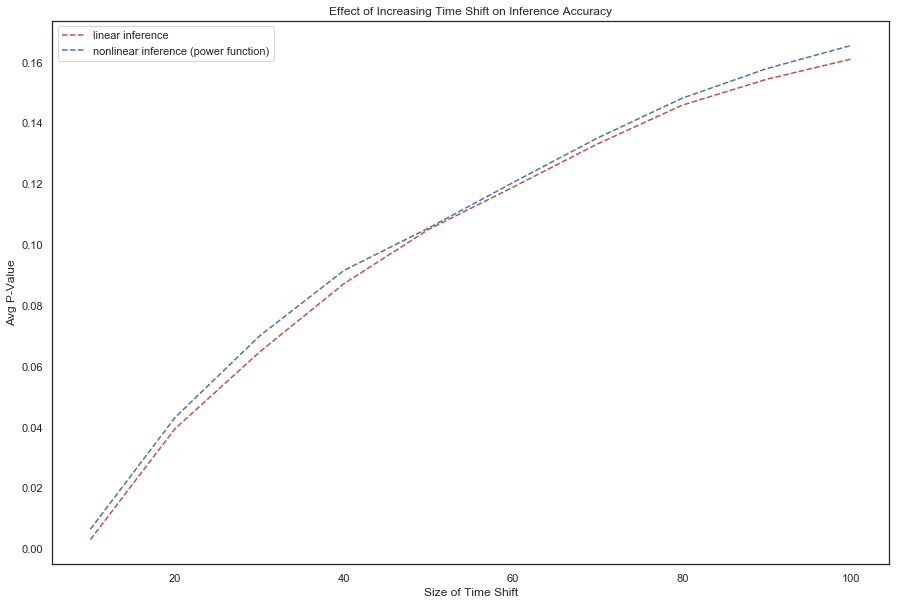

In [16]:
# plot p value by time shift here for both the linear and non linear methods
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(15,10)})
f = plt.figure()
plt.title('Effect of Increasing Time Shift on Inference Accuracy')
plt.xlabel('Size of Time Shift')
plt.ylabel('Avg P-Value')
plt.plot(timeshifts, pvalue_bytimeshift, 'r--', label='linear inference')
plt.plot(timeshifts, pvalue_bytimeshift_nl, 'b--', label='nonlinear inference (power function)')
plt.legend(loc = 'upper left')
plt.show()
f.savefig("linvnonlin_3.pdf", bbox_inches='tight')

In [ ]:
# plot p value by time shift here for both the linear and non linear methods
plt.plot(timeshifts, pvalue_linear_bytimeshift, 'r--')
plt.plot(timeshifts, pvalue_nonlinear_bytimeshift, 'b--')
plt.show()

In [ ]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
counter = 0
for patient in allwmatrices:
    w = allwmatrices[patient]
    sig = allsigs[patient]
    bias = allbiases[patient]
    
    w2 = allwmatrices2[patient]
    sig2 = allsigs2[patient]
    bias2 = allbiases2[patient]

    x_original = pca_data_dict[patient].T.copy()

    # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=1, bias=bias)
    
    simulated_data2 = simulate(pca_components, 1018, w=w2, sigma=sig2, rho=0, power=3, bias=bias2)

    # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
    tsc_original = time_shift_cov(x_original, shift=10)
    tsc_simulated = time_shift_cov(simulated_data[0], shift=10)
    tsc_simulated2 = time_shift_cov(simulated_data2[0], shift=10)

    line_object = linregress(tsc_original, tsc_simulated)
    line_object2 = linregress(tsc_original, tsc_simulated2)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    plt.plot(tsc_original, tsc_simulated2, 'bo', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    plt.plot(time_shift_axes, (line_object2.slope*time_shift_axes)+line_object2.intercept, 'b--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()

In [ ]:
for patient in allwmatrices2:
    w = allwmatrices[patient]
    sig = allsigs[patient]
    bias = allbiases[patient]

    x_original = pca_data_dict[patient].T.copy()

    # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=1)
    w_simulated, sig_simulated, bias_simulated = infer(simulated_data[0], power=power)
    
    line_object = linregress(w, w_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('W matrix original')
    plt.ylabel('W matrix simulated')
    plt.plot(w, w_simulated, 'ko', alpha=0.5)
    plt.plot([-1, 1], [-1,1], 'r--')
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    plt.show()
    print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    print("--------------------------------------------------------------")

In [ ]:
#try to quantify pvalue cutoffs for certain time shifts

#run pca on the first 2-3 components of the W matrices
pca_wmatrices = []
for patient in allwmatrices2:
    print(allwmatrices2[patient].shape)
    pca_wmatrices.append(allwmatrices2[patient].flatten())

In [ ]:
np.matrix(pca_wmatrices).shape

In [ ]:
pca_w = PCA(n_components=10)
pca_w.fit(np.matrix(pca_wmatrices))
transformed_data_w = pca_w.fit_transform(np.matrix(pca_wmatrices))

In [ ]:
pca_tscmatrices = []
for patient in pca_data_dict:
    pca_tscmatrices.append(time_shift_cov(pca_data_dict[patient].T, shift=40).flatten())

In [ ]:
pca_tsc = PCA(n_components=10)
pca_tsc.fit(np.matrix(pca_wmatrices))
transformed_data_tsc = pca_tsc.fit_transform(np.matrix(pca_tscmatrices))

In [ ]:
transformed_data_w.shape

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_w = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(transformed_data_w)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_w = {}
counter = 0
for grouping in clustering_w.labels_:
    if grouping not in cluster_dict_w:
        cluster_dict_w[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_w[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_w:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_w[key]))
    
cluster_number = len(cluster_dict_w.keys())

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_tsc = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(transformed_data_tsc)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_tsc = {}
counter = 0
for grouping in clustering_tsc.labels_:
    if grouping not in cluster_dict_tsc:
        cluster_dict_tsc[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_tsc[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_tsc:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_tsc[key]))
    
cluster_number = len(cluster_dict_tsc.keys())

In [ ]:
clustering_w.labels_

In [ ]:
plt.scatter(transformed_data_w[:, 0], transformed_data_w[:, 1], c=clustering_w.labels_, s=50, cmap='Spectral')

In [ ]:
pvalue_avg = []
rvalue_avg = []
for patient in cluster_dict_w[1]:
    w = allwmatrices2[patient]
    sig = allsigs2[patient]
    bias = allbiases2[patient]
    simulated_patient = np.zeros((1018, pca_components))
    
    for i in range(100):
        simulated_patient_temp = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=3)
        simulated_patient += simulated_patient_temp[0]
    simulated_patient = simulated_patient/20
    
    tsc_original = time_shift_cov(pca_data_dict[patient].T, shift=50)
    tsc_simulated = time_shift_cov(simulated_patient, shift=50)
    
    line_object = linregress(tsc_original, tsc_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()
    plt.close()
    print(line_object.pvalue)
    print(line_object.rvalue)
    pvalue_avg.append(line_object.pvalue)
    rvalue_avg.append(line_object.rvalue)

print('mean p', np.mean(pvalue_avg))
print('std p', np.std(pvalue_avg))
print()
print('mean r', np.mean(rvalue_avg))
print('std r', np.std(rvalue_avg))


In [ ]:
pvalue_avg = []
rvalue_avg = []
for patient in cluster_dict_tsc[7]:
    w = allwmatrices2[patient]
    sig = allsigs2[patient]
    bias = allbiases2[patient]
    
    
    simulated_patient = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=3)
    tsc_original = time_shift_cov(pca_data_dict[patient].T, shift=40)
    tsc_simulated = time_shift_cov(simulated_patient[0], shift=40)
    
    line_object = linregress(tsc_original, tsc_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()
    plt.close()
    print(line_object.pvalue)
    print(line_object.rvalue)
    pvalue_avg.append(line_object.pvalue)
    rvalue_avg.append(line_object.rvalue)

print('mean p', np.mean(pvalue_avg))
print('std p', np.std(pvalue_avg))
print()
print('mean r', np.mean(rvalue_avg))
print('std r', np.std(rvalue_avg))

In [ ]:
plt.scatter(transformed_data_w[:, 0], transformed_data_w[:, 1], c=clustering_tsc.labels_, s=50, cmap='Spectral')

In [ ]:
cluster_dict_w

In [ ]:
#try to quantify pvalue cutoffs for certain time shifts

#run pca on the first 2-3 components of the W matrices
pca_tscmatrices = []
for patient in pca_data_dict:
    pca_tscmatrices.append(time_shift_cov(pca_data_dict[patient].T, shift=time_shift).flatten())

In [ ]:
np.matrix(pca_tscmatrices).shape

In [ ]:
pca_tsc = PCA(n_components=2)
pca_tsc.fit(np.matrix(pca_tscmatrices))
transformed_data_tsc = pca_tsc.fit_transform(np.matrix(pca_tscmatrices))

In [ ]:
transformed_data_tsc.shape

In [ ]:
plt.scatter(transformed_data_tsc[:, 0], transformed_data_tsc[:, 1], c=clustering_tsc.labels_, s=50, cmap='Spectral')

In [ ]:
plt.scatter(transformed_data_tsc[:, 0], transformed_data_tsc[:, 1], c=clustering_w.labels_, s=50, cmap='Spectral')

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_tsc = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(transformed_data_tsc)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_tsc = {}
counter = 0
for grouping in clustering_tsc.labels_:
    if grouping not in cluster_dict_tsc:
        cluster_dict_tsc[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_tsc[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_tsc:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_tsc[key]))
    
cluster_number = len(cluster_dict_tsc.keys())

In [ ]:
#calculate the average w matrix for each cluster
avg_w_plot = {}
for key in cluster_dict_w:
    avg_w_matrix = np.zeros((pca_components, pca_components))
    count = 0
    for patient in cluster_dict_w[key]:
        avg_w_matrix += allwmatrices2[patient]
        count += 1
    avg_w_plot[key] = avg_w_matrix/count


In [ ]:
for key in avg_w_plot:
    for key2 in avg_w_plot:
        if key2 != key:
            line_object = linregress(avg_w_plot[key], avg_w_plot[key2])
            plt.title('Plot for ' + str(key) + ' and ' + str(key2))
            plt.plot(avg_w_plot[key], avg_w_plot[key2], 'ko', alpha=0.5)
            plt.plot([-1, 1], [-1,1], 'r--')
            time_shift_axes = np.arange(-1, 2)
            plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
            plt.show()
            plt.close()
            plt.show()
            print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
            print("--------------------------------------------------------------")

In [ ]:
for key in avg_w_plot:
    for key2 in avg_w_plot:
        if key2 != key:
            print(key, key2)
            subtract = avg_w_plot[key] - avg_w_plot[key2]
            seaborn.heatmap(subtract)
            plt.show()
            plt.close()

In [ ]:
# calculate the average tsc matrix for each cluster, and plot against each other
avg_tsc_plot = {}
for key in cluster_dict_tsc:
    avg_tsc_matrix = np.zeros((pca_components, pca_components))
    count = 0
    for patient in cluster_dict_tsc[key]:
        avg_tsc_matrix += time_shift_cov(pca_data_dict[patient].T, shift=time_shift)
        count += 1
    avg_tsc_plot[key] = avg_tsc_matrix/count

        


In [ ]:
for key in avg_tsc_plot:
    for key2 in avg_tsc_plot:
        if key2 != key:
            line_object = linregress(avg_tsc_plot[key], avg_tsc_plot[key2])
            plt.title('Plot for ' + str(key) + ' and ' + str(key2))
            plt.plot(avg_tsc_plot[key], avg_tsc_plot[key2], 'ko', alpha=0.5)
            plt.plot([-1, 1], [-1,1], 'r--')
            time_shift_axes = np.arange(-1, 2)
            plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
            plt.show()
            plt.close()
            plt.show()
            print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
            print("--------------------------------------------------------------")

In [ ]:
for key in avg_tsc_plot:
    for key2 in avg_tsc_plot:
        if key2 != key:
            subtract = avg_tsc_plot[key] - avg_tsc_plot[key2]
            seaborn.heatmap(subtract)
            plt.show()
            plt.close()

In [ ]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

def union(lst1, lst2):
    return list(set(lst1) | set(lst2))

In [ ]:
frequency_map = np.zeros((len(cluster_dict_w.keys()), len(cluster_dict_tsc.keys())))
for cluster in cluster_dict_w:
    for cluster2 in cluster_dict_tsc:
        if cluster2 > 2:
            frequency_map[cluster][cluster2-1] = len(intersection(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))/len(union(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))
        else:
            frequency_map[cluster][cluster2] = len(intersection(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))/len(union(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))
import seaborn
seaborn.heatmap(frequency_map, annot=True)    
plt.show()
plt.close()

In [ ]:
cluster_dict_w[1]

In [ ]:
cluster_dict_tsc[0]

In [ ]:
intersection(cluster_dict_w[1], cluster_dict_tsc[0])

In [ ]:
union(cluster_dict_w[1], cluster_dict_tsc[0])

In [ ]:
# are the same sets of patients in the same cluster groupings across time shift cov and w matrices?
for key in cluster_dict_w:
    print("Cluster", key, ":", cluster_dict_w[key])
print()
for key in cluster_dict_tsc:
    print("Cluster", key, ":", cluster_dict_tsc[key])
    
links = {}
for key in cluster_dict_w:
    for patient in cluster_dict_w[key]:
        for key2 in cluster_dict_tsc:
            for patient2 in cluster_dict_tsc[key2]:
                if patient == patient2:
                    #do something
                    links[patient] = (key, key2)
                    
# for key in cluster_dict_tsc:
#     for patient in cluster_dict_tsc[key]:
#         for key2 in cluster_dict_w:
#             for patient2 in cluster_dict_w[key2]:
#                 if patient == patient2:
#                     #do something
#                     links[patient] = (key, key2)

In [ ]:
links

In [ ]:
frequency_dict = {}
for value in links.values():
    if value not in frequency_dict:
        frequency_dict[value] = 1
    else:
        frequency_dict[value] += 1

for key in frequency_dict:
    if frequency_dict[key] >= 4 :
        print("Cluster Common Count:", key, "=", frequency_dict[key])

In [ ]:
# cluster_mapping_matrix = np.zeros((len(cluster_dict_w.keys()), len(cluster_dict_tsc.keys())))
# for key_w in cluster_dict_w:
#     for key_tsc in cluster_dict_tsc:
#         cluster_mapping_matrix[key_w][key_tsc] = len(intersection(cluster_dict_w[key_w], cluster_dict_tsc[key_tsc]))/len(union(cluster_dict_w[key_w], cluster_dict_tsc[key_tsc]))
        
# import seaborn
# seaborn.heatmap(cluster_mapping_matrix, annot=True)    
# plt.show()
# plt.close()


for num_clusters in range(4, 8):
    kmeans_labels_tsc = cluster.KMeans(n_clusters=num_clusters, random_state=42).fit_predict(flattened_tscmatrix_array)   
    kmeans_labels_w = cluster.KMeans(n_clusters=num_clusters, random_state=42).fit_predict(flattened_wmatrix_array)
    
    cluster_dict_kmeans_w = {}
    counter = 0
    for grouping in kmeans_labels_w:
        if grouping not in cluster_dict_kmeans_w:
            cluster_dict_kmeans_w[grouping] = [dataset_ids[counter]]
        else:
            cluster_dict_kmeans_w[grouping].append(dataset_ids[counter])
        counter = counter + 1

    cluster_dict_kmeans_tsc = {}
    counter = 0
    for grouping in kmeans_labels_tsc:
        if grouping not in cluster_dict_kmeans_tsc:
            cluster_dict_kmeans_tsc[grouping] = [dataset_ids[counter]]
        else:
            cluster_dict_kmeans_tsc[grouping].append(dataset_ids[counter])
        counter = counter + 1
     
    cluster_mapping_matrix = np.zeros((len(cluster_dict_kmeans_w.keys()), len(cluster_dict_kmeans_tsc.keys())))
    for key_w in cluster_dict_kmeans_tsc:
        for key_tsc in cluster_dict_kmeans_tsc:
            cluster_mapping_matrix[key_w][key_tsc] = len(intersection(cluster_dict_kmeans_w[key_w], cluster_dict_kmeans_tsc[key_tsc]))/len(union(cluster_dict_kmeans_w[key_w], cluster_dict_kmeans_tsc[key_tsc]))
    
    import seaborn
    seaborn.heatmap(cluster_mapping_matrix, annot=True)    
    plt.show()
    plt.close()

# Separator

In [ ]:
pca_wmatrix_dictionary = {}
counter = 0
for patient in allwmatrices2:
    pca_wmatrix_dictionary[patient] = transformed_data_w[counter*10:10*(counter+1), :].T
    counter = counter + 1

In [ ]:
pca_wmatrix_dictionary

In [ ]:
# spectral clustering, spectrally cluster the W matrices of all the patients to see if certain patients fall into 
# certain categories. Do for all 88 patients

# prepare a matrix to input into the spectral clustering function, must flatten all the W matrices
def wmatrix_clustering_prepare(allwmatrices):
    flattened_wmatrix_array = []
    unflattened_wmatrix_dict = {}
    counter = 0
    for patient in allwmatrices:
        flattened_matrix = allwmatrices[patient].flatten()
        unflattened_wmatrix_dict[counter] = allwmatrices[patient]
        if len(flattened_wmatrix_array) == 0:
            flattened_wmatrix_array = [flattened_matrix]
        else:
            flattened_wmatrix_array.append(flattened_matrix)
        counter = counter + 1
    return flattened_wmatrix_array, unflattened_wmatrix_dict

flattened_wmatrix_array, unflattened_wmatrix_dict = wmatrix_clustering_prepare(pca_wmatrix_dictionary)

# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_w = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(flattened_wmatrix_array)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_w = {}
counter = 0
for grouping in clustering_w.labels_:
    if grouping not in cluster_dict_w:
        cluster_dict_w[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_w[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_w:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_w[key]))
    
cluster_number = len(cluster_dict_w.keys())

In [ ]:
import umap
from sklearn.datasets import load_digits

standard_embedding_w = umap.UMAP(random_state=42).fit_transform(np.matrix(flattened_wmatrix_array))
w_embedded = TSNE(n_components=2, random_state=42).fit_transform(flattened_wmatrix_array)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})
plt.scatter(standard_embedding_w[:, 0], standard_embedding_w[:, 1], c=clustering_w.labels_, s=100, cmap='Spectral');
plt.show()
plt.close()

plt.scatter(w_embedded[:, 0], w_embedded[:, 1], c=clustering_w.labels_, s=100, cmap='Spectral');
plt.show()
plt.close()

In [ ]:
from sklearn.manifold import TSNE
sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})

w_embedded = TSNE(n_components=2, random_state=42).fit_transform(flattened_wmatrix_array)

import sklearn.cluster as cluster
kmeans_labels_w = cluster.KMeans(n_clusters=8, random_state=42).fit_predict(flattened_wmatrix_array)

plt.scatter(standard_embedding_w[:, 0], standard_embedding_w[:, 1], c=kmeans_labels_w, s=100, cmap='Spectral');
plt.show()
plt.close()

plt.scatter(w_embedded[:, 0], w_embedded[:, 1], c=kmeans_labels_w, s=100, cmap='Spectral');
plt.show()
plt.close()

In [ ]:
print(kmeans_labels_w)